In [1]:
!python -m pip install -r requirements.txt

Mounted at /content/drive
/content/drive/MyDrive/sick_nl-master
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.4 MB/s 
     |████████████████████████████████| 101 kB 12.4 MB/s 
     |████████████████████████████████| 596 kB 69.7 MB/s 
     |████████████████████████████████| 6.6 MB 39.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from evaluation.eval_nli import evaluate_en_nli_models, evaluate_nl_nli_models

In [4]:
import os
import pickle
import torch
from config import (models_folder, results_folder, bert, bert_nl)
from loaders.sick import load_sick_en, load_sick_nl
from loaders.nli_models import load_bert_nli_model
nl_sick = load_sick_nl()
en_sick = load_sick_en()

from transformers import BertForSequenceClassification
from models.bert_finetune import SICK_BERT_DATASET, BERTFineTuner
from transformers import BertTokenizer

# Data analysis

In [6]:
print("lengths of different splits:")
print(f"train data size: {len(nl_sick.train_data)}")
print(f"dev data size: {len(nl_sick.dev_data)}")
print(f"test data size: {len(nl_sick.test_data)}")
print(f"total data size: {len(nl_sick.data)}")

lengths of different splits:
train data size: 4439
dev data size: 495
test data size: 4906
total data size: 9840


Counter({'NEUTRAL': 2790, 'ENTAILMENT': 1404, 'CONTRADICTION': 712})
[('NEUTRAL', 56.87), ('ENTAILMENT', 28.62), ('CONTRADICTION', 14.51)]


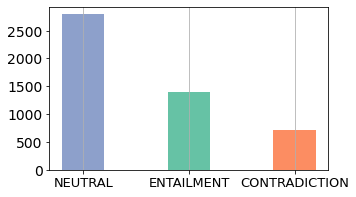

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('Set2')

def plot_distribution(dataset):
    label = [pair[2] for pair in dataset]
    print(Counter(label))

    labels, values = zip(*Counter(label).items())
    print([(i, round(v / len(label) * 100.0,2)) for i,v in Counter(label).items()])

    indexes = np.arange(len(labels))
    width = 0.4

    fig = plt.figure(figsize = (5,3))
    ax = fig.add_subplot(111)

    ax.xaxis.grid()
    plt.bar(indexes[0], values[0], width, color='C2')
    plt.bar(indexes[1], values[1], width, color='C0')
    plt.bar(indexes[2], values[2], width, color='C1')
    plt.xticks(indexes, labels, fontsize=13)
    plt.yticks(fontsize=14)
    plt.show()

plot_distribution(nl_sick.test_data)

# Load model functions

In [ ]:
# The following functions are adapted from the code by  Wijnholds and Moortgat 
# adaptations are marked by comments

def save_model(out_folder, model, dataset_name, name, epoch=1):
    model_name = name.split('/')[-1]
    out_fn = os.path.join(out_folder, f"model_{dataset_name}_{model_name}_epoch{epoch}.pt")
    torch.save(model, out_fn)


def load_results(fn):
    with open(fn, 'rb') as in_file:
        results = pickle.load(in_file)
    return results


def save_results(out_folder, results, dataset_name, name, epoch=1):
    model_name = name.split('/')[-1]
    out_fn = os.path.join(out_folder, f"results_{dataset_name}_{model_name}_epoch{epoch}.p")
    with open(out_fn, 'wb') as out_file:
        pickle.dump(results, out_file)


def get_epoch(fn):
    return int(fn.split('epoch')[-1].split('.')[0])


def consolidate_results_and_models(dataset_name, name, model_folder, result_folder):
    model_name = name.split('/')[-1]
    results_fns = [os.path.join(result_folder, fn)
                   for fn in os.listdir(result_folder)
                   if f"{dataset_name}_{model_name}" in fn]
    print(results_fns)
    print("Getting all results...")
    all_results = {get_epoch(fn): load_results(fn) for fn in results_fns}
    agg_result_folder = result_folder + '_agg'
    if not os.path.exists(agg_result_folder):
        os.mkdir(agg_result_folder)
    all_results_out_fn = os.path.join(agg_result_folder,
                                      f"results_{dataset_name}_{model_name}_epoch0-20.p")
    print("Saving all results...")
    with open(all_results_out_fn, 'wb') as out_file:
        pickle.dump(all_results, out_file)
    print("Removing superfluous result files...")
    for fn in results_fns:
        os.remove(fn)
    print("Getting best model...")
    ## Here, they select the model with the highest accuracy on the TEST SET!!!
    ## this really should be the dev....... so likely the model is overfitted to the
    ## testset this way :S 
    ### so... what I want to do is train, select the model with the best DEV score and 
    ### evaluate test score of this model. I want to do this 5 times and report the mean + std
    #### One further problem I have is that trainin after the first epoch does not appear to work?
    best_epoch = sorted(list(all_results.items()),
                        key=lambda d: d[1]['eval_accuracy'], reverse=True)[0][0]
    best_model_fn = os.path.join(model_folder,
                                 f"model_{dataset_name}_{model_name}_epoch{best_epoch}.pt")
    best_model = torch.load(best_model_fn)
    agg_model_folder = model_folder + '_agg'
    if not os.path.exists(agg_model_folder):
        os.mkdir(agg_model_folder)
    best_model_out_fn = os.path.join(agg_model_folder,
                                     f"model_{dataset_name}_{model_name}_epoch{best_epoch}.pt")
    torch.save(best_model, best_model_out_fn)
    print("Removing superfluous models...")
    models_fns = [os.path.join(model_folder, fn)
                  for fn in os.listdir(model_folder)
                  if f"{dataset_name}_{model_name}" in fn]
    for fn in models_fns:
        os.remove(fn)

# adapted this functions by 
# (i) removing the training loop that was present in the original code, 
# that caused the model to train for 1 epoch from scratch for the amount of epochs that was set; 
# (ii) adding more parameters in order to make the training more flexible, 
# e.g. by allowing to select what set to evaluate on; 
# and (iii) by allowing to define the number of training runs and the corresponding seeds
def run_finetuner(sick_dataset, name, eval_data, setting='bert', num_epochs=3, 
                  model_folder='models', result_folder='results', n_runs=1, seeds=[11]):
    for run in range(n_runs):
        tuner = load_bert_nli_model(sick_dataset, name, setting, sick_dataset.train_data, eval_data, num_epochs, seeds[run])
        epochs = num_epochs
        tuner.train()
        tuner.trainer.save_model(f'./{name}_model_run_{run}_{num_epochs}')
    return tuner

# adapted this function so that it can be used for both the english and the dutch datset
def eval_model(sick_dataset, name, run=1, num_epochs=1):
      model_name = f"./{name}_model_run_{run}_{num_epochs}"
      print(model_name)
      model = BertForSequenceClassification.from_pretrained(f"./{name}_model_run_{run}_{num_epochs}", num_labels=3)
      tokenizer = BertTokenizer.from_pretrained(name)
      train_dataset = SICK_BERT_DATASET(sick_dataset.test_data[:10], tokenizer)
      eval_dataset = SICK_BERT_DATASET(sick_dataset.test_data, tokenizer)
      trained_tuner = BERTFineTuner(name, tokenizer, model, train_dataset, eval_dataset, 42, num_epochs=0, freeze=True)
      return trained_tuner.evaluate()

# Train Dutch BERT, 1 epoch

In [ ]:
#perform 5 runs using different seeds
seeds = [11,22,33,44,55]
bertje = run_finetuner(nl_sick, bert_nl, nl_sick.test_data, setting='bert', num_epochs=1, model_folder=models_folder, result_folder=results_folder, n_runs=5, seeds=seeds)

Loading BERT model...


Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/417M [00:00<?, ?B/s]

Some weights of the model checkpoint at wietsedv/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wietsedv/bert-

Preparing datasets...
Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.657300,0.429809,0.835508,0.827993,0.838688,0.818539


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-278
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-dutch-cased/checkpoint-278 (score: 0.8355075417855687).
Saving model checkpoint to ./wietsedv/bert-base-dutch-cased_model_run_0_1
Configuration saved in ./wietsedv/bert-base-dutch-cased_model_run_0_1/config.json
Model weights saved in ./wietsedv/bert-base-dutch-cased_model_run_0_1/pytorch_model.bin


Loading BERT model...


loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/67c36a7a6f549d5b7c7f0c0eb4b0379f55015a54c5ab1a88909e12f900553b8b.2bab3c86db6bbfc2b6fe96a4a416e86c3d3a408fe0fb2eb53d5deb7d671280b9
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c6a1665d5ce2318e4defa6b1d6cc5a5ce12ad9f9861a3c6d28e76cfdc9727c75.c9201be1323c49787de3aab70bd869fbc376d46a1c44c7a0075d8e97358ab103
loading configuration file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/59a4c4f76ecdb084337ce0bfc62b3bf1044f6d3ef7b603

Preparing datasets...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.655400,0.440291,0.823889,0.818456,0.826132,0.811513


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-278
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-dutch-cased/checkpoint-278 (score: 0.8238891153689359).
Saving model checkpoint to ./wietsedv/bert-base-dutch-cased_model_run_1_1
Configuration saved in ./wietsedv/bert-base-dutch-cased_model_run_1_1/config.json
Model weights saved in ./wietsedv/bert-base-dutch-cased_model_run_1_1/pytorch_model.bin


Loading BERT model...


loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/67c36a7a6f549d5b7c7f0c0eb4b0379f55015a54c5ab1a88909e12f900553b8b.2bab3c86db6bbfc2b6fe96a4a416e86c3d3a408fe0fb2eb53d5deb7d671280b9
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c6a1665d5ce2318e4defa6b1d6cc5a5ce12ad9f9861a3c6d28e76cfdc9727c75.c9201be1323c49787de3aab70bd869fbc376d46a1c44c7a0075d8e97358ab103
loading configuration file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/59a4c4f76ecdb084337ce0bfc62b3bf1044f6d3ef7b603

Preparing datasets...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.649100,0.489849,0.810029,0.812038,0.802420,0.831238


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-278
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-dutch-cased/checkpoint-278 (score: 0.8100285364859355).
Saving model checkpoint to ./wietsedv/bert-base-dutch-cased_model_run_2_1
Configuration saved in ./wietsedv/bert-base-dutch-cased_model_run_2_1/config.json
Model weights saved in ./wietsedv/bert-base-dutch-cased_model_run_2_1/pytorch_model.bin


Loading BERT model...


loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/67c36a7a6f549d5b7c7f0c0eb4b0379f55015a54c5ab1a88909e12f900553b8b.2bab3c86db6bbfc2b6fe96a4a416e86c3d3a408fe0fb2eb53d5deb7d671280b9
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c6a1665d5ce2318e4defa6b1d6cc5a5ce12ad9f9861a3c6d28e76cfdc9727c75.c9201be1323c49787de3aab70bd869fbc376d46a1c44c7a0075d8e97358ab103
loading configuration file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/59a4c4f76ecdb084337ce0bfc62b3bf1044f6d3ef7b603

Preparing datasets...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.656700,0.463757,0.822258,0.819984,0.814157,0.828320


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-278
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-dutch-cased/checkpoint-278 (score: 0.8222584590297595).
Saving model checkpoint to ./wietsedv/bert-base-dutch-cased_model_run_3_1
Configuration saved in ./wietsedv/bert-base-dutch-cased_model_run_3_1/config.json
Model weights saved in ./wietsedv/bert-base-dutch-cased_model_run_3_1/pytorch_model.bin


Loading BERT model...


loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/67c36a7a6f549d5b7c7f0c0eb4b0379f55015a54c5ab1a88909e12f900553b8b.2bab3c86db6bbfc2b6fe96a4a416e86c3d3a408fe0fb2eb53d5deb7d671280b9
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c6a1665d5ce2318e4defa6b1d6cc5a5ce12ad9f9861a3c6d28e76cfdc9727c75.c9201be1323c49787de3aab70bd869fbc376d46a1c44c7a0075d8e97358ab103
loading configuration file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/59a4c4f76ecdb084337ce0bfc62b3bf1044f6d3ef7b603

Preparing datasets...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.663100,0.443862,0.829800,0.826715,0.834112,0.822624


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-278
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-dutch-cased/checkpoint-278 (score: 0.8298002445984509).
Saving model checkpoint to ./wietsedv/bert-base-dutch-cased_model_run_4_1
Configuration saved in ./wietsedv/bert-base-dutch-cased_model_run_4_1/config.json
Model weights saved in ./wietsedv/bert-base-dutch-cased_model_run_4_1/pytorch_model.bin


# Dutch BERT with original seed.. 1 epoch (reproducing the exact same setup)


In [ ]:
bertje = run_finetuner(nl_sick, bert_nl, nl_sick.test_data, setting='bert', num_epochs=1, model_folder=models_folder, result_folder=results_folder, n_runs=1, seeds=[42])

https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmprdoj72ap


Loading BERT model...


Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

storing https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/67c36a7a6f549d5b7c7f0c0eb4b0379f55015a54c5ab1a88909e12f900553b8b.2bab3c86db6bbfc2b6fe96a4a416e86c3d3a408fe0fb2eb53d5deb7d671280b9
creating metadata file for /root/.cache/huggingface/transformers/67c36a7a6f549d5b7c7f0c0eb4b0379f55015a54c5ab1a88909e12f900553b8b.2bab3c86db6bbfc2b6fe96a4a416e86c3d3a408fe0fb2eb53d5deb7d671280b9
https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpwj_fdcy4


Downloading:   0%|          | 0.00/236 [00:00<?, ?B/s]

storing https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/c6a1665d5ce2318e4defa6b1d6cc5a5ce12ad9f9861a3c6d28e76cfdc9727c75.c9201be1323c49787de3aab70bd869fbc376d46a1c44c7a0075d8e97358ab103
creating metadata file for /root/.cache/huggingface/transformers/c6a1665d5ce2318e4defa6b1d6cc5a5ce12ad9f9861a3c6d28e76cfdc9727c75.c9201be1323c49787de3aab70bd869fbc376d46a1c44c7a0075d8e97358ab103
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/67c36a7a6f549d5b7c7f0c0eb4b0379f55015a54c5ab1a88909e12f900553b8b.2bab3c86db6bbfc2b6fe96a4a416e86c3d3a408fe0fb2eb53d5deb7d671280b9
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/special_tokens_map.json from cache at None
loading file htt

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

storing https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/59a4c4f76ecdb084337ce0bfc62b3bf1044f6d3ef7b603f5405407924ec478f1.3b16931b59b9aafc3e068b6cd5f0be5e02a209a299e39b1e0056d89eaa3b6a7b
creating metadata file for /root/.cache/huggingface/transformers/59a4c4f76ecdb084337ce0bfc62b3bf1044f6d3ef7b603f5405407924ec478f1.3b16931b59b9aafc3e068b6cd5f0be5e02a209a299e39b1e0056d89eaa3b6a7b
loading configuration file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/59a4c4f76ecdb084337ce0bfc62b3bf1044f6d3ef7b603f5405407924ec478f1.3b16931b59b9aafc3e068b6cd5f0be5e02a209a299e39b1e0056d89eaa3b6a7b
Model config BertConfig {
  "_name_or_path": "wietsedv/bert-base-dutch-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "ge

Downloading:   0%|          | 0.00/417M [00:00<?, ?B/s]

storing https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/7a7191f5270caad7138d7e61b6e7a8e9d0eaad0d058a9faabb3896b520de8e9a.ead4c92543de4acacd907c329709df627a019151e95d79ced000d1199473fd29
creating metadata file for /root/.cache/huggingface/transformers/7a7191f5270caad7138d7e61b6e7a8e9d0eaad0d058a9faabb3896b520de8e9a.ead4c92543de4acacd907c329709df627a019151e95d79ced000d1199473fd29
loading weights file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/7a7191f5270caad7138d7e61b6e7a8e9d0eaad0d058a9faabb3896b520de8e9a.ead4c92543de4acacd907c329709df627a019151e95d79ced000d1199473fd29
Some weights of the model checkpoint at wietsedv/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.Laye

Preparing datasets...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.662700,0.470235,0.818589,0.817726,0.819651,0.820386


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-278
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-dutch-cased/checkpoint-278 (score: 0.8185894822666123).
Saving model checkpoint to ./wietsedv/bert-base-dutch-cased_model_run_0_1
Configuration saved in ./wietsedv/bert-base-dutch-cased_model_run_0_1/config.json
Model weights saved in ./wietsedv/bert-base-dutch-cased_model_run_0_1/pytorch_model.bin


IndexError: ignored

# Train Dutch BERT, 20 epochs

In [ ]:
bertje = run_finetuner(nl_sick, bert_nl, nl_sick.dev_data, setting='bert', num_epochs=20, model_folder=models_folder, result_folder=results_folder, n_runs=1, seeds=[66])

Loading BERT model...


Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/417M [00:00<?, ?B/s]

Some weights of the model checkpoint at wietsedv/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wietsedv/bert-

Preparing datasets...
Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5560


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.664600,0.491787,0.793939,0.780932,0.826066,0.751742
2,0.389500,0.518051,0.818182,0.808953,0.823703,0.799175
3,0.231800,0.682050,0.834343,0.818687,0.848167,0.802644
4,0.163600,0.873631,0.828283,0.820967,0.832946,0.812124
5,0.108400,0.985155,0.808081,0.796814,0.813949,0.782941
6,0.075600,1.004504,0.820202,0.804019,0.800643,0.808821
7,0.063500,1.083669,0.828283,0.822770,0.829254,0.817996
8,0.040400,1.294742,0.808081,0.797986,0.808691,0.788813
9,0.038500,1.142973,0.826263,0.803804,0.856363,0.770350
10,0.041000,1.333746,0.818182,0.803656,0.839105,0.778421


***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 1 0 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 1
 2 1 0 1 0 1 1 1 0 2 1 1 1 1 1 0 2 2 1 1 1 1 2 1 2 1 1 1 1 1 1 0 1 0 2 1 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 1 2 1 2 2 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1 0 1
 0 2 1 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 1 1 1 1 2 1 0 2 0
 1 1 1 2 1 1 1 1 0 0 1 1 1 1 1 0 0 1 2 1 1 1 0 2 2 2 1 1 1 1 1 2 1 1 2 1 2
 0 1 2 1 2 0 1 2 2 1 2 2 1 1 2 1 1 1 1 0 1 1 1 2 2 2 2 1 2 1 1 1 2 1 1 1 1
 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 2 0 2 2 2 1 0 0 0 1 0 1 0 0 1 1 1 1 1 2 1
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 1 0 2 0 1 1 1 2 1 1 1 1 1 2 1 2 1 2 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 1 1 1 0 1 1 1 1 0 2 1 1 1 1 1 1 1 2 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 1 2 1 1 1 1 1 2 1 1 2 1 1 2 1
 1 1 1 2 2 1 1 0 0 2 0 0 2 1 1 2 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 2 0 1 1 1 1
 0 2 2 2 1 1 2 1 1 2 2 2 1 1 0 2 1 2 2 1 1 1 2 2 2 1 2 1 1 1 2 1 1 1 1 2 1
 1 1 2 1 2 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 0 1 1 2 2 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-278
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-278/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 2 1 2 1 1 1
 2 2 1 1 0 1 2 1 0 2 1 1 1 2 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 2 1 1 0 1
 1 2 1 1 2 1 2 2 0 1 2 2 1 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 2 0 2 0
 1 1 0 2 0 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 1 0 2 1 2 1 1 1 2 2 2 1 1 2 2 2
 0 1 2 1 2 1 1 2 2 1 2 2 1 1 2 2 1 2 1 0 0 2 1 2 1 1 2 1 2 1 2 1 2 0 0 2 1
 0 0 1 1 1 1 2 0 0 1 2 1 1 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 1 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 2 0 1 1 2 1 1 1 1 2 2 2 1 1 0 1 1 1 1 0 2 1 1 1 1 2 2 1 2 1 2
 1 2 2 0 1 1 1 1 1 1 0 1 1 2 0 1 1 2 1 2 1 1 2 2 1 1 1 1 1 2 1 1 2 1 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 1 0 1 1 1 1
 0 2 2 2 1 1 2 1 2 2 2 2 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 2 1 1 1 1 0 1
 1 1 2 1 2 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 1 1 1 2 2 1 2 1 1 1 1 2 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-556
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-556/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-556/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 0 1 2 1 2 1 1 1
 2 2 1 2 0 1 2 1 0 2 1 1 1 1 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 2 1 1 0 1
 1 2 1 1 2 1 2 1 0 1 2 2 1 2 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 1 1 2 1 1 1 1 0 0 2 2 1 1 1 0 0 2 2 1 1 1 0 2 1 2 1 1 1 2 2 2 1 1 1 2 2
 1 2 2 1 2 1 1 2 2 1 2 2 1 1 1 1 1 2 1 1 0 1 1 2 1 1 2 1 2 1 1 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 1 2 1 2 1 1 2 2 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 2 1 2 0 1 1 2 1 1 1 1 2 2 2 1 2 0 1 1 1 1 0 2 1 1 1 1 2 2 1 2 1 2
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 0 1 1 2 1 2 1 1 2 2 1 1 1 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 2 1 2 2 1 2 2 2 2 1 1 0 2 1 2 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 2 2 2 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 2 1 1 1 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 2 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-834
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-834/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-834/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 2 1 1 1 1 0 1 1 1 1 0 1 2 1 2 1 1 1
 2 2 0 1 0 1 2 1 0 2 0 1 1 1 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 2 1 1 0 1
 1 2 1 1 2 1 1 1 0 1 2 2 1 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 1 0 2 0
 1 1 1 2 1 0 1 1 0 0 1 2 0 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 2 1 1 2 2 2
 0 1 2 1 2 1 1 2 2 1 2 2 1 1 2 1 1 2 1 0 0 1 1 2 1 1 1 1 2 1 1 1 2 1 0 2 1
 0 0 1 0 1 1 2 0 0 1 2 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 1 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 2 0 1 1 2 1 1 1 1 2 2 2 1 2 0 1 1 1 1 0 2 1 1 1 1 2 2 1 2 1 2
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 0 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1
 0 2 2 2 1 1 2 1 2 1 2 2 1 1 0 2 1 2 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 2 2 2 1 1 1 1 1 1 1 2 1 2 2 1 1 1 2 1 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-1112
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-1112/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-1112/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 2 2 1 1 1 1 0 1 1 1 1 0 1 2 1 2 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 1 1 0 2 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 0 1 1 2 2 1 1 1 2 2 1 2 1 1 0 1
 0 2 1 1 2 1 1 1 0 1 2 2 2 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 2 0 2 0
 1 1 0 2 0 1 1 1 0 0 1 2 1 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 2 1 1 1 1 2
 0 1 2 1 2 1 1 2 1 1 2 2 1 1 2 1 1 2 1 0 0 1 1 2 1 1 1 1 2 1 1 1 2 1 0 2 1
 0 0 1 1 1 1 2 0 0 1 2 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 1 2 2
 0 2 2 1 0 1 1 2 2 1 1 0 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 2 1 1 0 1 1 1 1 0 2 1 1 1 1 2 1 1 2 1 2
 1 1 2 0 1 1 1 1 1 1 0 1 1 2 0 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 1 1 0 0 2 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1
 1 2 2 2 1 1 2 1 2 1 2 1 1 1 0 2 1 1 2 1 1 1 1 1 2 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 0 1 1 2 2 1 2 1 2 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-1390
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-1390/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-1390/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 2 2 1 1 1 1 0 1 1 2 1 0 1 2 1 2 1 1 1
 2 2 1 1 0 1 2 1 0 2 0 1 1 1 1 0 2 1 1 0 1 1 2 1 2 1 1 1 1 1 1 1 1 0 2 0 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 0 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 1 1 0 1 2 2 2 0 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 2 0 2 0
 1 1 0 2 0 0 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 1 0 2 1 2 0 1 1 2 2 1 1 1 2 0 2
 0 1 2 1 1 1 1 2 1 1 2 2 1 1 1 1 1 2 1 0 0 0 1 2 1 1 0 1 2 1 1 1 2 0 0 2 1
 0 0 1 0 1 1 2 0 0 1 1 1 1 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 1 2 2
 0 2 2 1 0 1 1 2 2 1 1 0 1 0 1 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 0 1 2 0 1 1 1 1 0 2 1 1 1 1 2 2 1 2 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 2 0 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 1 1 0 0 2 0 0 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 2 0 1 1 1 1
 0 2 2 2 1 1 2 1 2 0 2 1 1 1 0 2 1 2 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 0 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-1668
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-1668/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-1668/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 2 1 2 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 1 1 0 2 1 1 2 1 1 2 1 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 0 1 1 2 2 1 1 1 2 2 1 2 1 1 0 1
 0 2 1 1 2 1 2 1 0 1 2 2 1 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 2 0 2 0
 1 1 0 2 1 0 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 1 0 2 1 2 1 1 1 2 2 1 1 1 2 2 2
 0 1 2 1 2 1 0 2 2 1 2 2 0 1 2 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 0 2 1
 0 0 1 1 2 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 2 1 1 2 1 0 1 2 2
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 1 1 2 0 1 1 1 1 0 1 1 1 1 1 2 2 1 2 1 1
 1 1 2 0 1 1 1 1 1 1 0 1 1 2 0 1 1 2 2 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 2 1 1 2 1 2 1 2 1 1 1 0 2 1 2 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-1946
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-1946/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-1946/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 2 1 0 1 2 1 2 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 1 1 0 2 1 1 2 1 1 2 1 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 2 1 0 1 2 2 1 2 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 2 0 2 0
 1 1 1 1 1 1 1 1 0 0 1 2 0 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 1 1 1 1 2 2 2
 0 1 2 1 2 1 0 2 1 1 2 2 2 1 2 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 0 2 1
 0 0 1 1 2 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 2 1 1 2 1 0 1 2 2
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 0 1 2 0 1 1 1 0 0 2 1 1 1 1 2 2 1 2 1 1
 1 1 2 0 1 1 1 1 1 1 0 1 1 2 0 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 1 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 2 0 1 1 1 1
 0 2 1 2 1 1 2 1 2 1 2 1 1 1 0 2 1 2 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 0 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 2 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-2224
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-2224/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-2224/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 2 1 2 1 1 1
 2 2 1 1 0 1 2 1 0 2 1 1 1 1 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 2 2 1 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 1 1 1 1 2 2 1 2 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 1 0 2 0
 1 1 1 2 1 1 1 1 0 0 1 2 1 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 1 1 1 1 2 1 2
 0 1 2 1 2 1 1 2 1 1 2 2 1 1 1 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 1 1 2 1 1 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 1 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 1 2 2
 0 2 2 1 0 1 1 2 2 1 1 0 1 0 2 1 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 1 1 2 0 1 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1 2 1
 1 1 1 1 2 1 1 0 0 1 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 1 2 1 1 1 1 2 1 2 1 1 1 1 1 0 2 1 2 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-2502
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-2502/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-2502/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 2 1 0 1 2 1 1 1 1 1
 2 2 1 2 0 1 2 1 0 2 1 1 1 2 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 1 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 2 1 1 1 2 2 1 2 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 2 0 2 0
 1 1 1 2 1 1 1 1 0 0 1 2 1 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 1 1 1 1 2 1 2
 0 1 2 1 2 1 1 2 1 1 2 2 1 1 1 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 0 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 1 0 1 0 1 0 0 2 0 1 1 1 2 2
 0 2 2 1 0 1 1 2 2 1 1 0 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 1 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 1 1 2 0 1 1 1 1 0 1 1 1 1 1 2 1 1 2 1 1
 1 1 2 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 1 1 2 2 1 1 1 1 1 2 1 1 2 1 1 2 1
 1 1 1 2 2 1 1 0 0 2 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 1 2 1 1 2 1 2 1 1 1 1 1 0 2 1 1 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-2780
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-2780/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-2780/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 2 1 2 1 1 0 1 1 2 1 0 1 2 1 1 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 2 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 2 1 1 1 2 2 0 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 2 0 2 0
 1 1 0 2 1 1 1 1 0 0 1 2 0 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 1 1 1 2 1 2
 0 1 2 1 2 1 0 2 2 1 2 2 1 1 2 1 1 2 1 0 0 0 1 2 1 1 0 1 2 1 2 1 2 1 0 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 0 1 2 0 1 1 1 0 0 2 1 1 1 1 2 2 1 2 1 1
 1 1 2 0 1 1 1 1 1 1 0 1 1 2 0 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 1 2 1 1 2 1 2 1 1 1 1 1 0 2 1 2 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-3058
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-3058/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-3058/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 2 1 2 1 1 0 1 1 1 1 0 1 2 1 1 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 2 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 2 1 1 1 2 2 0 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 2 0 2 0
 1 1 0 2 1 1 1 1 0 0 1 2 1 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 1 1 1 2 1 2
 0 1 2 1 2 1 1 2 2 1 2 2 1 1 2 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 0 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 2 1 2 0 1 1 1 0 0 2 1 1 1 1 2 2 1 2 1 1
 1 1 2 0 1 1 1 1 1 1 0 1 1 2 0 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 1 2 1 1 2 1 2 1 1 1 1 1 0 2 1 2 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-3336
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-3336/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-3336/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 2 1 1 1 1 1
 2 2 1 2 0 1 2 1 0 2 1 1 1 1 1 0 2 1 1 2 1 1 2 1 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 1 1 1 1 2 2 1 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 1 0 2 0
 1 1 0 2 1 0 1 1 0 0 1 2 1 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 1 1 1 2 1 2
 0 1 2 1 2 1 1 2 2 1 2 2 1 1 1 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 1 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 1 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 1 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 2 1 2 0 1 1 1 1 0 1 1 1 1 1 2 2 1 2 1 1
 1 1 2 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 1 1 2 1
 1 1 1 2 2 1 1 0 0 2 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 1 2 1 1 2 1 2 1 1 1 1 1 0 2 1 1 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-3614
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-3614/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-3614/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 2 1 0 1 2 1 1 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 2 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 2 1 1 1 2 2 2 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 2 0 2 0
 1 1 0 2 1 0 1 1 0 0 1 2 1 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 1 1 1 2 1 2
 0 1 2 1 2 1 1 2 2 1 2 2 1 1 2 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 1 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 2 1 2 0 1 1 1 1 0 2 1 1 1 1 2 2 1 2 1 1
 1 2 2 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 1 2 1 1 2 1 2 1 1 2 1 1 0 2 1 2 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 2 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-3892
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-3892/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-3892/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 2 1 0 1 2 1 1 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 2 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 0 2 1 1 2 1 2 1 1 1 2 2 0 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 1 0 2 0
 1 1 0 2 0 0 1 1 0 0 1 2 0 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 1 1 1 2 1 2
 0 1 2 1 2 1 1 2 2 1 2 2 1 1 1 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 0 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 1 2 2
 0 2 2 1 0 1 1 2 2 1 1 0 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 1 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 2 1 2 0 1 1 1 0 0 2 1 1 1 1 2 2 1 2 1 1
 1 2 2 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 2 1 1 2 1 2 2 1 2 1 1 0 2 1 1 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 0 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-4170
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-4170/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-4170/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1 0 1 2 1 1 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 1 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 1 1 1 1 2 2 0 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 1 0 2 0
 1 1 0 2 0 0 1 1 0 0 1 2 1 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 1 1 1 2 1 2
 0 1 2 1 2 1 1 2 2 1 2 2 1 1 1 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 1 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 1 2 2
 0 2 2 1 0 1 1 2 2 1 1 0 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 2 1 2 0 1 1 1 0 0 2 1 1 1 1 2 2 1 2 1 1
 1 1 2 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 2 1 1 2 1 2 2 1 1 1 1 0 2 1 1 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 0 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-4448
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-4448/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-4448/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1 0 1 2 1 2 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 1 1 0 2 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 1 1 1 1 2 2 0 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 1 0 2 0
 1 1 0 2 0 0 1 1 0 0 1 2 1 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 1 1 1 2 1 2
 0 1 2 1 2 1 1 2 2 1 2 2 1 1 2 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 1 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 1 2 2
 0 2 2 1 0 1 1 2 2 1 1 0 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 1 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 2 1 2 0 1 1 1 0 0 2 1 1 1 1 2 2 1 2 1 1
 1 1 0 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 1 2 1 1 2 1 2 2 1 1 1 1 0 2 1 1 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 0 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-4726
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-4726/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-4726/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1 0 1 2 1 1 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 2 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 2 1 1 1 2 2 1 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 1 0 2 0
 1 1 0 2 0 0 1 1 0 0 1 2 1 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 1 1 1 2 1 2
 0 1 2 1 2 1 1 2 1 1 2 2 1 1 2 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 1 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 1 2 2
 0 2 2 1 0 1 1 2 2 1 1 0 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 2 1 2 0 1 1 1 1 0 2 1 1 1 1 2 2 1 2 1 1
 1 1 2 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 1 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 1 2 1 1 2 1 2 2 1 1 1 1 0 2 1 1 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 0 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-5004
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-5004/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-5004/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1 0 1 2 1 2 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 2 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 2 1 1 1 2 2 1 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 2 0 2 0
 1 1 0 2 0 0 1 1 0 0 1 2 1 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 1 1 1 2 1 2
 0 1 2 1 2 1 1 2 2 1 2 2 1 1 2 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 1 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 0 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 2 1 2 0 1 1 1 1 0 2 1 1 1 1 2 2 1 2 1 1
 1 1 2 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 1 2 1 1 2 1 2 2 1 2 1 1 0 2 1 1 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 0 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-5282
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-5282/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-5282/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 2 1 0 1 2 1 2 1 1 1
 2 2 1 2 0 1 2 1 0 2 0 1 1 2 1 0 2 1 1 2 1 1 2 2 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 1 2 2 1 1 1 1 0 1
 1 2 1 1 2 1 2 1 1 1 2 2 1 2 1 1 2 2 0 2 0 1 1 2 1 1 1 2 2 1 1 1 2 2 0 2 0
 1 1 0 2 0 0 1 1 0 0 1 2 1 1 1 0 0 1 2 1 1 1 0 2 1 2 1 1 1 2 2 1 1 1 2 1 2
 0 1 2 1 2 1 1 2 2 1 2 2 1 1 2 1 1 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 1 1 2 1
 0 0 1 1 1 1 2 0 0 1 1 1 2 1 1 2 2 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 2 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 1 1 1 1 1 1 0 1 1 2 1 1 1 1 2 2 2 1 2 0 1 1 1 1 0 2 1 1 1 1 2 2 1 2 1 1
 1 1 2 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 2 1 1 2 1 2 2 1 2 1 1 0 2 1 1 2 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 0 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-dutch-cased/checkpoint-5560
Configuration saved in ./results2_bert-base-dutch-cased/checkpoint-5560/config.json
Model weights saved in ./results2_bert-base-dutch-cased/checkpoint-5560/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-dutch-cased/checkpoint-834 (score: 0.8343434343434344).
Saving model checkpoint to ./wietsedv/bert-base-dutch-cased_model_run_0_20
Configuration saved in ./wietsedv/bert-base-dutch-cased_model_run_0_20/config.json
Model weights saved in ./wietsedv/bert-base-dutch-cased_model_run_0_20/pytorch_model.bin


In [ ]:
eval_model(nl_sick, f"{bert_nl}", run=0, num_epochs=20)

loading configuration file ./wietsedv/bert-base-dutch-cased_model_run_0_20/config.json
Model config BertConfig {
  "_name_or_path": "wietsedv/bert-base-dutch-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 3,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 300

./wietsedv/bert-base-dutch-cased_model_run_0_20


All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at ./wietsedv/bert-base-dutch-cased_model_run_0_20.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/67c36a7a6f549d5b7c7f0c0eb4b0379f55015a54c5ab1a88909e12f900553b8b.2bab3c86db6bbfc2b6fe96a4a416e86c3d3a408fe0fb2eb53d5deb7d671280b9
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/wietsedv/bert-base-dutch-cased/resolve/main/tok

[1 2 1 ... 1 1 1]


{'eval_accuracy': 0.8406033428454953,
 'eval_f1': 0.8379792323097499,
 'eval_loss': 0.6091704368591309,
 'eval_precision': 0.8475324959047735,
 'eval_recall': 0.8330890064700623,
 'eval_runtime': 33.6361,
 'eval_samples_per_second': 145.855,
 'eval_steps_per_second': 2.289}

# Train English BERT, 1 epoch

In [ ]:
#perform 5 runs using different seeds
seeds = [11,22,33,44,55]
run_finetuner(en_sick, bert, en_sick.test_data, setting='bert', num_epochs=1, model_folder=models_folder, result_folder=results_folder, n_runs=5, seeds=seeds)

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217

Loading BERT model...


loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2

Preparing datasets...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.699700,0.469329,0.822870,0.822284,0.821507,0.830889


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-cased/checkpoint-278
Configuration saved in ./results2_bert-base-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-cased/checkpoint-278 (score: 0.8228699551569507).
Saving model checkpoint to ./bert-base-cased_model_run_0_1
Configuration saved in ./bert-base-cased_model_run_0_1/config.json
Model weights saved in ./bert-base-cased_model_run_0_1/pytorch_model.bin
loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791


Loading BERT model...


loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidde

Preparing datasets...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.699600,0.446787,0.835508,0.828178,0.830855,0.826169


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-cased/checkpoint-278
Configuration saved in ./results2_bert-base-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-cased/checkpoint-278 (score: 0.8355075417855687).
Saving model checkpoint to ./bert-base-cased_model_run_1_1
Configuration saved in ./bert-base-cased_model_run_1_1/config.json
Model weights saved in ./bert-base-cased_model_run_1_1/pytorch_model.bin
loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface

Loading BERT model...


loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2

Preparing datasets...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.691800,0.488701,0.812271,0.813748,0.806974,0.833204


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-cased/checkpoint-278
Configuration saved in ./results2_bert-base-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-cased/checkpoint-278 (score: 0.8122706889523033).
Saving model checkpoint to ./bert-base-cased_model_run_2_1
Configuration saved in ./bert-base-cased_model_run_2_1/config.json
Model weights saved in ./bert-base-cased_model_run_2_1/pytorch_model.bin
loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface

Loading BERT model...


loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2

Preparing datasets...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.674800,0.433068,0.845495,0.839543,0.839964,0.839228


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-cased/checkpoint-278
Configuration saved in ./results2_bert-base-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-cased/checkpoint-278 (score: 0.8454953118630248).
Saving model checkpoint to ./bert-base-cased_model_run_3_1
Configuration saved in ./bert-base-cased_model_run_3_1/config.json
Model weights saved in ./bert-base-cased_model_run_3_1/pytorch_model.bin


Loading BERT model...


loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217

Preparing datasets...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.691400,0.404741,0.847534,0.838039,0.852739,0.825895


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-cased/checkpoint-278
Configuration saved in ./results2_bert-base-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-cased/checkpoint-278 (score: 0.8475336322869955).
Saving model checkpoint to ./bert-base-cased_model_run_4_1
Configuration saved in ./bert-base-cased_model_run_4_1/config.json
Model weights saved in ./bert-base-cased_model_run_4_1/pytorch_model.bin


# English BERT with original seed.. 1 epoch


In [ ]:
bertje = run_finetuner(en_sick, bert, en_sick.test_data, setting='bert', num_epochs=1, model_folder=models_folder, result_folder=results_folder, n_runs=1, seeds=[42])

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217

Loading BERT model...


loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.4",
  "type_vocab_size": 2

Preparing datasets...


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 278


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.716200,0.414285,0.852426,0.847109,0.853339,0.841941


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


Saving model checkpoint to ./results2_bert-base-cased/checkpoint-278
Configuration saved in ./results2_bert-base-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-278/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-cased/checkpoint-278 (score: 0.852425601304525).
Saving model checkpoint to ./bert-base-cased_model_run_0_1
Configuration saved in ./bert-base-cased_model_run_0_1/config.json
Model weights saved in ./bert-base-cased_model_run_0_1/pytorch_model.bin


# English BERT with original seed, 20 epochs

In [ ]:
bertje = run_finetuner(en_sick, bert, en_sick.dev_data, setting='bert', num_epochs=20, model_folder=models_folder, result_folder=results_folder, n_runs=1, seeds=[42])

Loading BERT model...


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Preparing datasets...
Loading finetuning model...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4439
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5560


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.712600,0.559155,0.789899,0.797729,0.790410,0.826738
2,0.415900,0.372837,0.876768,0.870541,0.877865,0.868290
3,0.306100,0.443294,0.870707,0.867424,0.856645,0.886854
4,0.237300,0.451511,0.872727,0.862258,0.886616,0.842874
5,0.179500,0.540819,0.860606,0.843857,0.855242,0.834761
6,0.118800,0.566092,0.868687,0.862960,0.867459,0.859115
7,0.087100,0.728482,0.876768,0.873866,0.869445,0.881180
8,0.073200,0.781518,0.874747,0.863032,0.849158,0.881139
9,0.049700,0.774347,0.876768,0.865035,0.860100,0.870729
10,0.035100,0.779701,0.890909,0.885167,0.882344,0.888413


***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 2 1 2 1 2 2 2 0 1 2 1 2 1 2 2 1 2 2 1 2 1 1 0 1 1 2 1 0 1 2 1 2 2 1 1
 2 2 0 2 0 2 2 1 0 2 1 1 1 1 1 0 2 2 2 2 1 1 2 2 2 1 2 2 1 2 1 0 1 0 2 2 0
 1 1 1 0 2 1 2 2 1 2 2 0 2 1 2 2 2 2 2 1 2 0 1 1 2 2 1 1 1 2 2 1 1 1 2 0 1
 0 2 1 1 2 2 1 1 0 0 2 2 2 2 1 1 2 1 0 2 0 1 1 2 2 1 1 2 2 1 1 1 2 1 0 2 0
 1 1 1 2 0 0 1 1 0 0 1 2 0 1 1 1 0 2 2 1 1 2 0 2 2 2 1 1 2 2 2 2 1 1 2 1 2
 0 2 2 1 2 0 0 2 2 1 2 2 1 1 1 2 0 2 1 0 0 2 1 2 2 2 2 0 2 2 2 1 2 0 0 1 1
 0 0 1 1 1 1 1 0 0 2 2 1 1 1 1 2 1 0 2 2 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 2 2 1 2 1 2 2 2 2 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 2 1 2 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 2 1 1 1 1 1 2 1 2 1 2
 1 2 1 0 1 0 1 1 0 1 0 1 1 2 0 1 1 2 1 2 0 1 2 1 1 1 2 1 1 0 1 1 2 2 1 2 0
 1 1 1 2 2 2 2 0 0 2 0 1 2 1 1 2 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 2 1 1
 0 2 2 2 1 1 2 0 2 2 2 1 1 1 0 2 0 2 2 2 2 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 1
 1 1 2 2 2 2 1 1 2 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 0 1 1 2 2 2 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-278
Configuration saved in ./results2_bert-base-cased/checkpoint-278/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-278/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 2 1 2 0 1 1 1 2 1 1 2 1 1 2 1 2 1 1 0 1 1 1 1 0 1 1 1 2 2 1 1
 2 2 0 1 0 2 2 1 0 2 1 1 1 1 2 0 2 2 1 1 1 1 2 1 2 1 1 1 1 2 1 0 1 0 2 1 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 1 2 2 2 2 1 2 1 1 1 1 2 1 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 1 2 2 2 2 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 1 0 2 2 2 1 1 2 2 2 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 1 1 1 1 0 2 1 0 0 1 1 2 2 2 2 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 1 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 2 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 2 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 1 1 1 1 1 1 2 1 1 2 2 2 2 1
 1 1 1 2 2 2 1 0 0 2 0 1 2 1 1 1 2 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 2 1 1 1 0 2 2 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 2 1 2 1 1 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 0 1 1 2 2 1 2 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-556
Configuration saved in ./results2_bert-base-cased/checkpoint-556/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-556/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 1 1 2 2 2 0 1 1 1 2 1 1 1 1 1 2 1 2 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 2 0 1 0 1 2 1 0 2 1 1 1 1 2 0 2 2 1 2 1 1 2 2 2 1 2 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 1 2 2 2 2 1 1 0 1 1 1 2 0 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 2 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 1 0 2 2 2 1 1 2 2 2 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 2 2 1 1 0 2 1 0 0 1 1 2 2 2 2 1 2 1 2 1 2 0 0 2 1
 0 0 1 0 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 0 2 1 2 1 1 2 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 2 2 1 0 2 1 1 0 1 1 2 1 2 1 1
 1 2 2 0 1 0 1 2 0 1 0 1 1 2 1 1 1 2 1 2 0 1 2 2 1 1 1 1 1 2 1 1 2 2 2 2 1
 1 1 1 2 2 2 1 0 0 1 0 0 2 1 1 1 2 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 0 1
 0 2 2 2 1 1 1 1 2 2 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 2 2 1 1 1 2 1
 1 1 2 2 2 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 2 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-834
Configuration saved in ./results2_bert-base-cased/checkpoint-834/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-834/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 2 1 2 0 1 1 1 2 1 1 1 1 1 2 1 1 1 1 0 1 1 1 1 0 1 1 1 1 2 1 1
 2 2 1 1 0 1 2 1 0 1 1 1 1 1 1 0 2 2 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 0 2 2 0
 1 1 1 0 1 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 1 1 1 1 1 2 1 1 1 2 2 1 2 1 1 0 1
 0 1 1 2 2 1 1 1 0 1 2 2 2 2 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 1 1 2 1 1 1 1 0 0 1 2 1 1 1 0 0 2 2 1 1 1 0 2 2 2 1 1 2 2 1 2 1 1 2 1 2
 0 2 2 1 1 0 1 2 1 1 2 2 1 1 1 1 0 2 1 0 0 1 1 2 1 1 2 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 1 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 2 1 1 0 1 1 2 1 2 1 1 1 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 2 1 1 1 1 1 2 1 1 1 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 2 1 1 0 1 1 1 1
 0 2 2 1 1 1 1 1 2 1 1 1 1 1 0 2 1 1 2 1 2 1 1 2 2 1 1 1 1 1 1 2 1 1 1 2 1
 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-1112
Configuration saved in ./results2_bert-base-cased/checkpoint-1112/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-1112/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 2 1 2 0 1 1 1 2 1 1 1 1 1 2 1 1 1 1 0 1 1 1 1 0 1 2 1 1 2 1 1
 2 1 0 1 0 1 2 1 0 1 1 1 1 1 1 0 2 1 1 1 1 1 2 1 2 1 1 1 1 1 1 0 1 0 2 1 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 1 0 1 1 1 2 1 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 1 1 2 2 2 2 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 1 0 2 0
 1 1 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 1 0 2 2 2 1 1 2 2 1 2 1 1 2 1 2
 0 2 2 1 1 0 1 2 1 1 2 2 1 1 1 1 0 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 0 1 1 1
 0 0 1 1 1 1 2 0 0 2 1 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 1 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 1 1 2 1 1 2 1 0 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 1 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 2 1 1 1 1 1 2 1 1 0 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 2 0 1 0 1 1 1 1
 0 2 2 1 1 1 1 0 2 1 1 1 1 1 0 2 1 1 0 1 2 1 1 1 2 1 1 1 2 1 1 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 1 1 1 1 2 1 2 1 2 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-1390
Configuration saved in ./results2_bert-base-cased/checkpoint-1390/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-1390/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 1 1 2 1 2 0 1 1 1 2 1 1 1 1 2 2 1 2 1 1 0 1 1 1 1 0 1 2 1 1 2 1 1
 2 2 0 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 1 2 1 1 1 1 2 1 0 1 0 2 1 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 1 2 2 2 2 1 1 1 1 1 1 2 0 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 1 0 2 2 2 1 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 2 0 2 2 2 1 1 2 2 2 1 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 2 1 1 1 0 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 1 1 1 2 1 0 1 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 2 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 1 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 2 2 1 1 1 2 1 2 0 1 2 1 1 1 1 1 1 2 1 1 2 2 2 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 0 1
 0 2 2 1 1 1 1 1 2 1 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 1 2 1 1 1 2 1
 1 1 1 2 2 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 1 2 1 2 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-1668
Configuration saved in ./results2_bert-base-cased/checkpoint-1668/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-1668/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 1 1 2 1 2 0 1 1 1 2 1 1 1 1 2 2 1 2 1 1 0 1 1 1 1 0 1 2 1 1 2 1 1
 2 2 1 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 1 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 0 1 1 1 2 0 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 2 1 1 2 1 0 2 0 1 1 2 2 1 1 2 2 2 1 1 2 2 0 2 0
 1 1 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 2 0 2 2 2 1 1 2 2 2 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 2 1 1 1 0 2 1 0 0 2 1 2 1 1 2 1 2 1 2 1 2 0 1 2 1
 0 0 1 0 1 1 2 0 0 2 1 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 2 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 2 1 1 1 1 1 2 1 1 2 2 2 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 0 2 0 1 1 0 1
 0 2 2 1 1 1 1 0 2 2 1 1 1 1 0 2 1 1 2 1 2 1 2 2 2 1 1 1 2 1 2 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 2 2 1 1 1 2 0 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-1946
Configuration saved in ./results2_bert-base-cased/checkpoint-1946/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-1946/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 1 1 2 1 2 0 1 1 1 2 1 1 1 1 0 2 1 2 1 1 0 1 1 2 1 0 1 2 1 0 2 1 1
 2 2 0 1 0 1 2 1 0 1 0 1 1 1 2 0 2 2 1 1 1 1 2 1 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 2 0 1 1 1 2 0 2 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 1 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 1 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 2 0 2 2 2 0 1 2 2 2 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 2 1 1 1 0 2 1 0 0 0 1 2 1 1 2 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 2 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 2 2 1 0 1 1 1 0 1 1 2 1 2 1 1
 1 2 2 0 1 0 1 1 0 1 0 1 1 2 1 1 1 2 1 2 0 1 2 1 1 1 1 1 1 2 1 1 0 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 0 1
 0 2 2 1 1 1 1 1 2 2 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 1 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 2 2 1 2 1 2 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-2224
Configuration saved in ./results2_bert-base-cased/checkpoint-2224/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-2224/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 1 1 2 1 2 0 1 1 1 2 1 1 1 1 2 2 1 2 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 2 0 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 2 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 1 0 1 1 1 2 0 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 2 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 1 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 2 0 2 2 2 1 1 2 2 1 2 1 1 2 2 2
 0 2 2 1 1 0 1 1 2 1 2 2 1 1 1 1 0 2 1 0 0 1 1 2 1 1 2 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 1 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 1 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 2 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 0 1 1 0 1 0 1 1 2 1 1 1 2 1 2 0 1 2 1 1 1 1 1 1 2 1 1 0 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 1 1 1 1 0 2 1 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 2 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-2502
Configuration saved in ./results2_bert-base-cased/checkpoint-2502/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-2502/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 1 1 2 1 2 0 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 0 1 2 1 0 2 1 1
 2 2 1 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 2 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 1 0 1 1 1 2 1 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 1 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 2 0 2 2 2 1 1 2 2 1 2 1 1 2 2 2
 0 2 2 1 1 0 1 1 2 1 2 2 1 1 1 1 0 2 1 0 0 0 1 2 1 1 0 1 2 1 2 1 2 0 1 2 1
 0 0 1 0 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 1 1 1 1 2 1 2 1 1 0 2 1 2 1
 1 1 1 2 2 2 1 0 0 1 0 0 2 1 1 0 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 1 1 1 1 1 2 2 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 1 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-2780
Configuration saved in ./results2_bert-base-cased/checkpoint-2780/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-2780/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 1 1 2 2 2 0 1 1 1 2 1 1 1 1 2 2 1 2 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 2 0 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 1 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 2 0 1 1 1 2 1 2 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 1 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 2 0 2 2 2 0 1 2 2 1 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 2 1 1 1 0 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 0 1 2 1
 0 0 1 0 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 0 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 2 1 1 1 1 1 2 1 1 2 2 2 2 1
 1 1 1 2 2 2 1 0 0 1 0 0 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 1 1 1 1 1 2 1 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 1 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-3058
Configuration saved in ./results2_bert-base-cased/checkpoint-3058/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-3058/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 1 1 2 1 2 0 1 1 1 2 1 1 1 1 1 2 1 1 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 1 1 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 1 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 1 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 2 0 1 1 1 2 1 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 1 0 2 2 2 1 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 1 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 1 0 2 2 2 1 1 2 2 1 1 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 1 1 1 1 0 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 1 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 1 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 1 1 1 1 1 1 2 1 1 2 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 1 1 1 1 1 2 1 1 1 1 1 0 2 1 1 2 1 2 1 2 2 2 1 1 1 2 1 1 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-3336
Configuration saved in ./results2_bert-base-cased/checkpoint-3336/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-3336/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 2 1 2 0 1 1 1 2 1 1 1 1 2 2 1 2 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 2 0 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 2 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 2 0 1 1 1 2 0 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 2 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 2 0 2 2 2 0 1 2 2 1 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 1 1 1 1 0 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 0 1 2 1
 0 0 1 0 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 2 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 0 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 2 1 1 1 1 1 2 1 1 2 2 2 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 2 1 1 1 0 2 1 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 1 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-3614
Configuration saved in ./results2_bert-base-cased/checkpoint-3614/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-3614/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 2 1 2 0 1 1 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 2 1 1 0 1 0 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 1 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 2 0 1 1 1 2 1 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 1 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 1 0 2 2 2 0 1 2 2 1 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 1 1 1 1 0 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 1 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 1 1 1 1 1 1 2 1 1 0 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 1 1 1 1 0 2 1 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 1 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-3892
Configuration saved in ./results2_bert-base-cased/checkpoint-3892/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-3892/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 2 1 2 0 1 1 1 2 1 1 1 1 2 2 1 1 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 2 1 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 2 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 2 0 1 1 1 2 1 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 1 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 0 1 1 0 0 2 2 1 1 1 0 2 2 2 0 1 2 2 1 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 1 1 1 1 0 2 1 0 0 1 1 2 1 1 2 1 2 1 2 1 2 0 1 2 1
 0 0 1 0 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 0 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 2 1 1 1 1 1 2 1 1 0 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 0 1
 0 2 2 1 1 1 1 0 2 1 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 2 2 1 1 1 2 1
 1 1 2 2 2 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-4170
Configuration saved in ./results2_bert-base-cased/checkpoint-4170/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-4170/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 2 1 2 0 1 1 1 2 1 1 1 1 2 2 1 2 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 2 0 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 2 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 2 0 1 1 1 2 1 2 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 2 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 2 1 1 0 0 2 2 1 1 1 0 2 2 2 0 1 2 2 1 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 2 1 1 1 0 2 1 0 0 1 1 2 1 1 2 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 2 1 1 1 1 1 2 1 1 0 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 0 1
 0 2 2 1 1 1 1 0 2 1 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 2 2 1 1 1 2 1
 1 1 2 2 2 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-4448
Configuration saved in ./results2_bert-base-cased/checkpoint-4448/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-4448/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 2 1 2 0 1 1 1 2 1 1 1 1 2 2 1 1 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 2 1 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 2 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 2 0 1 1 1 2 1 2 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 1 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 2 1 2 2 1 1 0 0 2 2 1 1 1 0 2 2 2 0 1 2 2 1 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 2 1 1 1 0 2 1 0 0 1 1 2 1 1 2 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 2 1 1 1 1 1 2 1 1 1 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 2 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 1 1 1 1 0 2 1 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 2 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-4726
Configuration saved in ./results2_bert-base-cased/checkpoint-4726/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-4726/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 2 1 2 0 1 1 1 2 1 1 1 1 2 2 1 2 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 2 1 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 2 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 2 0 1 1 1 2 1 2 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 1 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 2 1 1 0 0 2 2 1 1 1 0 2 2 2 0 1 2 2 1 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 2 1 1 1 0 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 1 1 1 1 1 1 2 1 1 1 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 1 1 1 1 0 2 1 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 2 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-5004
Configuration saved in ./results2_bert-base-cased/checkpoint-5004/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-5004/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 2 1 2 0 1 1 1 2 1 1 1 1 2 2 1 2 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 2 1 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 2 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 2 0 1 1 1 2 1 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 1 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 2 1 1 0 0 2 2 1 1 1 0 2 2 2 0 1 2 2 1 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 2 1 1 1 0 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 1 1 1 1 1 1 2 1 1 1 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 1 1 1 1 0 2 1 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 2 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-5282
Configuration saved in ./results2_bert-base-cased/checkpoint-5282/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-5282/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 495
  Batch size = 64


[0 1 1 1 2 1 2 1 2 0 1 1 1 2 1 1 1 1 2 2 1 1 1 1 0 1 1 1 1 0 1 2 1 2 2 1 1
 2 2 1 1 0 1 2 1 0 1 1 1 1 1 2 0 2 2 1 1 1 1 2 2 2 1 1 1 1 2 1 0 1 0 2 2 0
 1 1 2 0 2 1 2 2 1 2 1 1 2 1 0 2 2 2 2 1 2 0 1 1 1 2 1 1 1 2 2 1 2 1 1 0 1
 0 2 1 2 2 1 1 1 0 0 2 2 2 1 1 1 2 1 0 2 0 1 1 2 1 1 1 2 2 2 1 1 2 2 0 2 0
 1 2 1 2 1 1 1 1 0 0 1 2 2 1 1 0 0 2 2 1 1 1 0 2 2 2 0 1 2 2 1 2 1 1 2 2 2
 0 2 2 1 1 0 1 2 2 1 2 2 2 1 1 1 0 2 1 0 0 1 1 2 1 1 0 1 2 1 2 1 2 0 1 2 1
 0 0 1 1 1 1 2 0 0 2 2 1 1 1 1 2 1 0 2 1 2 1 0 0 0 1 0 1 0 0 2 0 1 1 2 2 2
 0 2 2 1 0 1 1 2 2 1 1 2 1 0 2 0 2 0 1 2 1 2 1 1 1 1 1 2 2 1 1 2 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 2 1 2 1 1 2 2 2 1 2 0 1 1 2 1 0 1 1 1 1 1 1 2 1 2 1 1
 1 2 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 2 1 2 0 1 2 1 1 1 1 1 1 2 1 1 1 2 1 2 1
 1 1 1 2 2 2 1 0 0 2 0 0 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 2 0 1 1 1 1
 0 2 2 1 1 1 1 0 2 1 1 1 1 1 0 2 1 2 2 1 2 1 2 2 2 1 1 1 2 1 2 2 1 1 1 2 1
 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 0 2 1 1 0 1 1 1 2 1 2 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 

Saving model checkpoint to ./results2_bert-base-cased/checkpoint-5560
Configuration saved in ./results2_bert-base-cased/checkpoint-5560/config.json
Model weights saved in ./results2_bert-base-cased/checkpoint-5560/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results2_bert-base-cased/checkpoint-3336 (score: 0.8929292929292929).
Saving model checkpoint to ./bert-base-cased_model_run_0_20
Configuration saved in ./bert-base-cased_model_run_0_20/config.json
Model weights saved in ./bert-base-cased_model_run_0_20/pytorch_model.bin


In [ ]:
eval_model(en_sick, bert, run=0, num_epochs=20)


***** Running Evaluation *****
  Num examples = 4906
  Batch size = 64


[1 1 1 ... 1 1 1]


{'eval_accuracy': 0.8787199347737464,
 'eval_f1': 0.868911369801936,
 'eval_loss': 0.9480268359184265,
 'eval_precision': 0.8763526878160718,
 'eval_recall': 0.8620301356830292,
 'eval_runtime': 32.0324,
 'eval_samples_per_second': 153.158,
 'eval_steps_per_second': 2.404}